Based on original chris' repository

In [5]:
import sys
sys.path.append("..")

# from metrics.m1 import m1, metrics.m2 import m2...

from pathlib import Path
from tqdm import tqdm
import librosa
import numpy as np
import matplotlib.pyplot as plt

from src.echohiding import get_cepstrum, get_z_score, get_median_z_score, get_local_peak_z
import torch

# ddsp
sys.path.append("../ddsp")
from ddsp.model import DDSPDecoder

# dance diffusion
from dance_diffusion.audio_diffusion.utils import load_model_for_synthesis, do_style_transfer


MODELS_ROOT = Path("../ArtistProtectModels/SingleEchoes")

example_file = Path("/home/tomek/datasets/GuitarSet/00_BN1-129-Eb_comp_mic.wav")

ModuleNotFoundError: No module named 'ddsp'

In [6]:
# Check if models are downloaded

if not any(MODELS_ROOT.iterdir()):
    raise RuntimeError("Download the models first")

FileNotFoundError: [Errno 2] No such file or directory: '../ArtistProtectModels/SingleEchoes'

In [3]:
# Set seeds

np.random.seed(1234)
torch.manual_seed(1234)

## DDSP

In [4]:
def get_ddsp_cepstra(checkpoint: Path, sr: int, files: list[Path], lag_start = 25, lag_end = 125) -> np.ndarray:
    """Returns cepstrum obtained by doing style transfer with given checkpoint. Works for many files and reuses single model

    Args:
        checkpoint (Path): ddsp checkpoint (.pkl)
        sr (int): sample rate
        files (list[Path]): audio files to process
        lag_start: beginning of cepstrum slice
        lag_end: end of cepstrum slice
    """

    dur = 5


    torch.set_grad_enabled(False)

    model = DDSPDecoder(3, 512, 50, 65, 441, sr, sr)
    model.load_from_file(checkpoint) # this will throw an error probably

    cepstra = []  
    for fidx, f in tqdm(enumerate(files)):
        torch.cuda.empty_cache()
        x, _ = librosa.load(f, sr=sr)
        print(f"Doing file {f}, {fidx+1}/{len(files)}, length {x.size//sr} sec")
        with torch.no_grad():
            y = model.style_transfer(x, "cpu", "cuda")
        if y.size < dur*sr:
            print(f, "too short for", dur)
            continue
        i1 = np.random.randint(y.size-dur*sr) # Choose a random offset
        cep = get_cepstrum(y[i1:i1+sr*dur])
        csort = np.array(cep[0:lag_end+1])
        csort[0:lag_start] = -np.inf
        cepstra.append(csort)
        
    return np.stack(cepstra)
            

cepstra_ddsp = get_ddsp_cepstra(MODELS_ROOT/"DDSP/groove_75.pkl", 44100,[example_file])


0it [00:00, ?it/s]

Doing file /home/tomek/datasets/GuitarSet/00_BN1-129-Eb_comp_mic.wav, 1/1, length 22 sec
Elapsed time pitch: 0.673861026763916


/home/tomek/github/hidden-echoes/.venv/lib/python3.12/site-packages/librosa/core/convert.py:1869: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
1it [00:03,  3.16s/it]

Elapsed time synth: 0.48335862159729004


## RAVE

In [ ]:

def get_rave_cepstra(checkpoint: Path, sr: int, files: list[Path], lag_start = 25, lag_end = 125) -> np.ndarray:
    """Returns cepstrum obtained by doing style transfer with given checkpoint. Works for many files and reuses single model

    Args:
        checkpoint (Path): RAVE checkpoint (.ts)
        sr (int): sample rate
        files (list[Path]): audio files to process
        lag_start: beginning of cepstrum slice
        lag_end: end of cepstrum slice
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    dur = 5

    torch.set_grad_enabled(False)
    model = torch.jit.load(checkpoint).eval()
    model = model.to(device)

    cepstra = []  
    for fidx, f in tqdm(enumerate(files)):
        x, _ = librosa.load(f, sr=sr)
        with torch.no_grad():
            z = model.encode(torch.from_numpy(x).to(device).reshape(1,1,-1))
            y = model.decode(z).cpu().numpy().reshape(-1)
        if y.size < dur*sr:
            print(f, "too short for", dur)
            continue
        i1 = np.random.randint(y.size-dur*sr) # Choose a random offset
        cep = get_cepstrum(y[i1:i1+sr*dur])
        csort = np.array(cep[0:lag_end+1])
        csort[0:lag_start] = -np.inf

        cepstra.append(csort)

    return np.stack(cepstra)
    

cepstra_rave = get_rave_cepstra(MODELS_ROOT/"Rave"/"groove_75.ts", 44100, [example_file])


1it [00:00,  3.97it/s]


## DanceDiffusion

This model had requirement of 60 seconds of audio, I changed it to 20, seems to work.

In [24]:
def get_dancediffusion_cepstra(checkpoint: Path, sr: int, files: list[Path], lag_start = 25, lag_end = 125) -> np.ndarray:
    """Returns cepstrum obtained by doing style transfer with given checkpoint. Works for many files and reuses single model

    Args:
        checkpoint (Path): dance diffusion checkpoint (.ckpt)
        sr (int): sample rate
        files (list[Path]): audio files to process
        lag_start: beginning of cepstrum slice
        lag_end: end of cepstrum slice
    """

    torch.set_grad_enabled(False)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    sample_size = 81920 # from diffusion_echo.py
    dur = 5
    min_dur = 20 # it was 60 originally for some reasaon
    noise_level = 0.1 # 0.2

    model = load_model_for_synthesis(checkpoint, sample_size, sr, device)

    cepstra = []
    for fidx, f in enumerate(files):
        x, _ = librosa.load(f, sr=sr)
        if x.size < sr*min_dur:
            print(f"{f} too short, skipping")
            continue
        else:
            idx = np.random.randint(x.size-sr*min_dur)
            xi = x[idx:idx+sr*min_dur]
            n = sample_size*(xi.size//sample_size)
            xi = xi[0:n]
            xi = torch.from_numpy(xi[None, None, :]).to(device)
            y = do_style_transfer(model, xi, steps=100, noise_level=noise_level,device=device)
            y = y.detach().cpu().numpy()[0, 0, :]

            i1 = 0
            if dur < min_dur:
                i1 = np.random.randint(y.size-dur*sr) # Choose a random offset
            cep = get_cepstrum(y[i1:i1+sr*dur])
            csort = np.array(cep[0:lag_end+1])
            csort[0:lag_start] = -np.inf
            cepstra.append(csort)
    return np.stack(cepstra)

cepstra_dd = get_dancediffusion_cepstra(MODELS_ROOT/"DanceDiffusion"/"groove_75.ckpt", 44100, [example_file])

/home/tomek/github/hidden-echoes/.venv/lib/python3.12/site-packages/diffusion/sampling.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


## Compare metrics

In [25]:
from collections import defaultdict
metrics = {"DDSP": defaultdict(), "RAVE": defaultdict(), "DanceDiffusion": defaultdict()}

for model, cep in zip(metrics.keys(), (cepstra_ddsp, cepstra_rave, cepstra_dd)):
    if cep is not None:
        metrics[model]["z_score"] = get_z_score(cep[0], 75, 0, 25)
        metrics[model]["mad_z_score"] = get_median_z_score(cep[0],75)
        metrics[model]["blurry_z_score"] = get_median_z_score(cep[0],75, search_width=3)



for key in metrics.keys():
    print(key)
    print(metrics[key])

DDSP
defaultdict(None, {'z_score': np.float64(14.072520317772671)})
RAVE
defaultdict(None, {'z_score': np.float64(11.24946241880238)})
DanceDiffusion
defaultdict(None, {'z_score': np.float64(4.618824402930532)})


Text(0.5, 1.0, 'DDSP cepstrum')

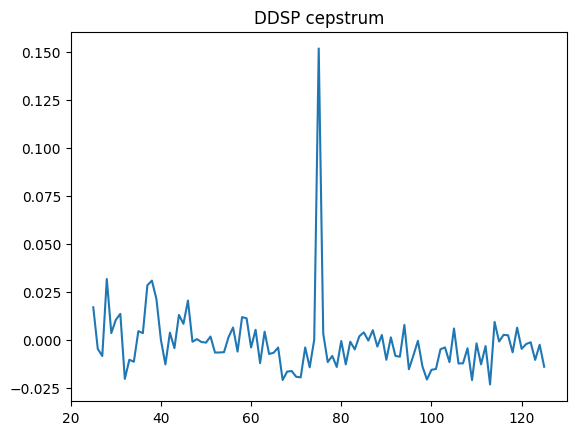

In [26]:
plt.plot(cepstra_ddsp[0])
plt.title("DDSP cepstrum")

Text(0.5, 1.0, 'RAVE cepstrum')

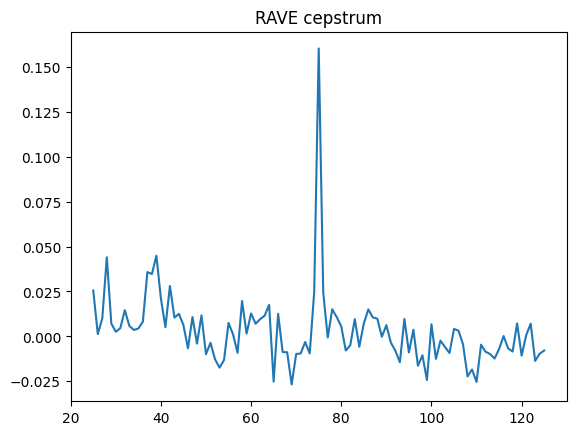

In [27]:
plt.plot(cepstra_rave[0])
plt.title("RAVE cepstrum")

Text(0.5, 1.0, 'Dance Diffusion cepstrum')

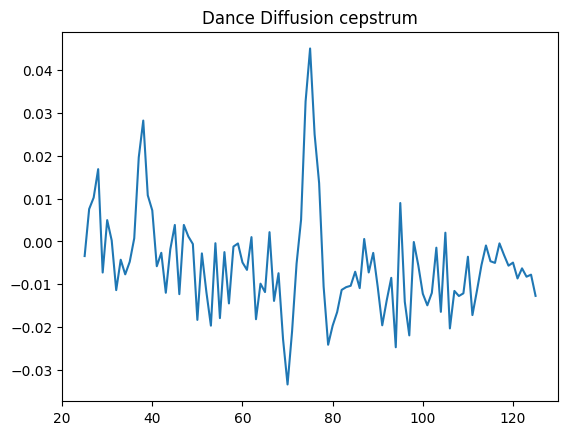

In [28]:
plt.plot(cepstra_dd[0])
plt.title("Dance Diffusion cepstrum")